# Exploratory data analysis kernel

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

### Key points to remember
- Objective: assemble a portfolio **for the next year**
- Use of external, publicly available data is permitted
- SRRI (Synthetic Risk and Reward Indicator) should be at the level of 3 or 4
- Portfolio-making decisions should be reproducable for any given starting point (possibly in the future, with new data)

### Immediate next steps to do:
- Implement SRRI calculation for model validation
- Research possible data sources

## Loading data and initial checks

In [2]:
data = pd.read_csv('./input/Quant_Invest_Fundusze.csv', sep=';')
data.index = pd.to_datetime(data['Daty'])
data['Daty'] = pd.to_datetime(data['Daty'])  # duplicated index for easy use of seaborn
ts_cols = [col for col in data.columns if not col == 'Daty']
data[ts_cols] = data[ts_cols].astype(np.float32) # reduce float size for speed and less RAM
data.sort_index(inplace=True)

In [3]:
data.head(15)

,Daty,AP,ARR,ARW,G,OP,ORR,ORW
Daty,,,,,,,,
2000-01-03,2000-01-03,415.899994,549.109985,354.450012,401.260010,275.079987,520.130005,230.720001
2000-01-04,2000-01-04,404.410004,533.890015,357.140015,401.420013,275.079987,520.020020,229.630005
2000-01-05,2000-01-05,400.040009,527.380005,351.190002,401.589996,275.079987,519.219971,229.220001
2000-01-06,2000-01-06,410.149994,522.020020,347.959991,401.750000,275.070007,519.619995,228.820007
2000-01-07,2000-01-07,429.160004,533.159973,351.869995,401.929993,275.070007,520.799988,230.089996
2000-01-10,2000-01-10,442.040009,538.530029,361.299988,402.450012,275.070007,521.130005,230.240005
2000-01-11,2000-01-11,437.660004,536.900024,355.820007,402.630005,275.070007,519.070007,228.460007
2000-01-12,2000-01-12,434.579987,534.010010,357.429993,402.809998,275.059998,518.390015,227.880005
2000-01-13,2000-01-13,447.459991,538.330017,362.250000,402.980011,275.059998,519.849976,228.979996


In [4]:
data['Daty'].diff().dt.days.agg(['min', 'max', 'mean', 'std'])

min     1.000000
max     5.000000
mean    1.445208
std     0.849548
Name: Daty, dtype: float64

Looks like we have data for all working days, as expected.

In [5]:
data.shape

(4801, 8)

In [6]:
data.isna().sum()

Daty    0
AP      0
ARR     0
ARW     0
G       0
OP      0
ORR     0
ORW     0
dtype: int64

No NULL fields, that's good.

### Preprocessing for tsfresh and seaborn

In [7]:
preproessed_dfs = [
    pd.DataFrame({
        'date': data[col].index.copy(),
        'fund': col,
        'val': data[col].copy()
    }) for col in ts_cols
]
preprocessed_data = pd.concat(preproessed_dfs, ignore_index=True).sort_values(by='date')

In [8]:
preprocessed_data.head(10)

,date,fund,val
0,2000-01-03,AP,415.899994
19204,2000-01-03,OP,275.079987
14403,2000-01-03,G,401.260010
9602,2000-01-03,ARW,354.450012
28806,2000-01-03,ORW,230.720001
4801,2000-01-03,ARR,549.109985
24005,2000-01-03,ORR,520.130005
4802,2000-01-04,ARR,533.890015
9603,2000-01-04,ARW,357.140015
28807,2000-01-04,ORW,229.630005


In [9]:
preprocessed_data.shape

(33607, 3)

## Basic statistical properties

In [10]:
data[ts_cols].agg(['min', 'max', 'mean', 'std', 'skew', 'kurtosis'])

,AP,ARR,ARW,G,OP,ORR,ORW
min,263.190002,310.250000,198.839996,401.260010,273.730011,517.929993,226.529999
max,1140.979980,1156.300049,1257.619995,1000.000000,1000.000000,1032.500000,1055.189941
mean,708.177856,647.427856,703.366821,790.078003,654.723816,784.218994,621.785889
std,242.924179,205.323105,289.584381,165.551483,209.836121,145.538696,250.163925
skew,-0.321315,0.612106,-0.379628,-0.507294,-0.043134,0.024126,0.101750
kurtosis,-1.188721,-0.519859,-1.291582,-0.805649,-1.123011,-1.253942,-1.300556


In [17]:
data[ts_cols].groupby([data.index.year, data.index.quarter]).std().agg(['mean', 'max'])

,AP,ARR,ARW,G,OP,ORR,ORW
mean,23.535702,15.237221,23.264193,2.286787,4.738468,5.149070,8.327688
max,65.996460,38.881847,72.517609,6.412915,14.284174,14.577169,26.979042


In [32]:
std_inspect_threshold = 50


  0%|          | 0/76 [00:00<?, ?it/s]

Group data, std=63.718441009521484


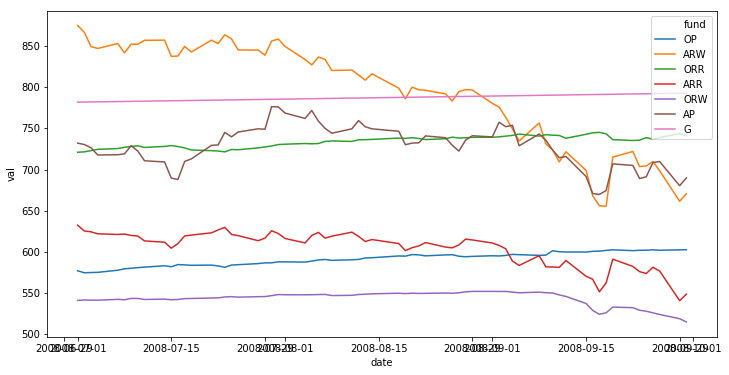


 46%|████▌     | 35/76 [00:00<00:00, 69.07it/s]

Group data, std=51.873680114746094


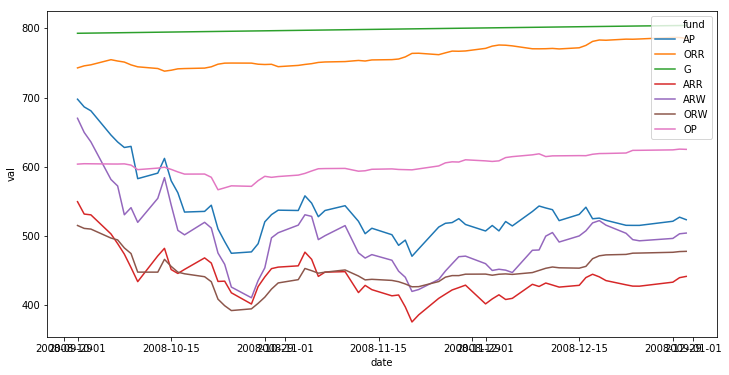

Group data, std=50.111793518066406


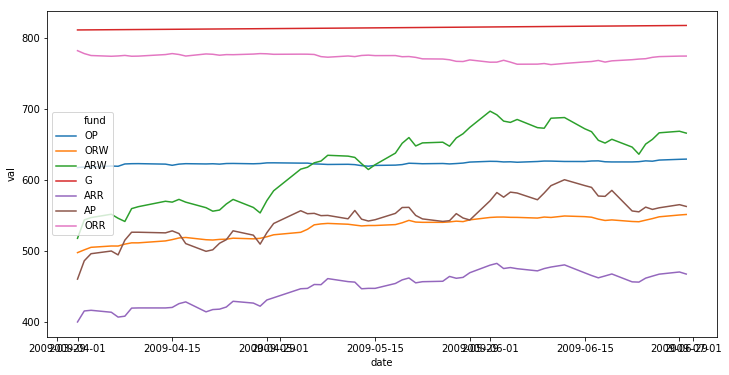


 50%|█████     | 38/76 [00:01<00:03, 11.14it/s]

Group data, std=72.51760864257812


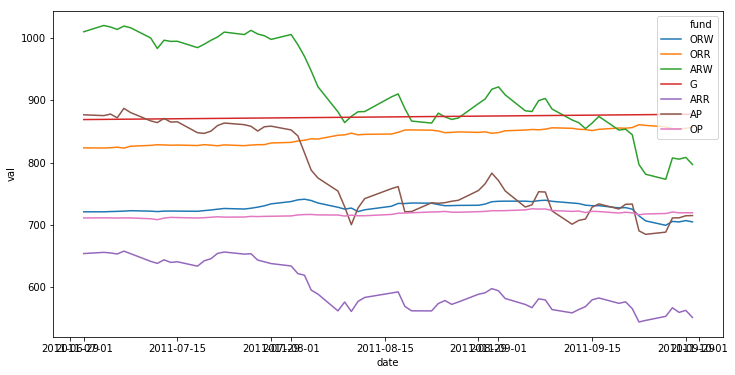


 62%|██████▏   | 47/76 [00:01<00:02, 13.25it/s]

Group data, std=52.147708892822266


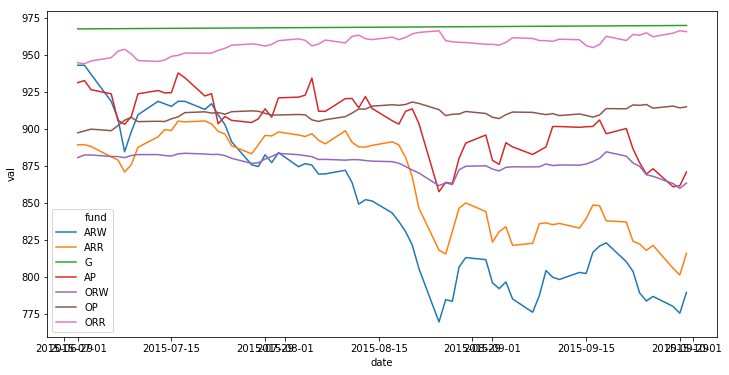


100%|██████████| 76/76 [00:02<00:00, 35.25it/s]

In [33]:
# finding some interesting quarters to plot
for _, group_data in tqdm(preprocessed_data.groupby([preprocessed_data['date'].dt.year, preprocessed_data['date'].dt.quarter])):
    std_max_val = group_data.groupby('fund').std().max().max()
    if std_max_val > std_inspect_threshold:
        print(f'Group data, std={std_max_val}')
        _, ax = plt.subplots(figsize=(12, 6))
        sns.lineplot(data=group_data, x='date', y='val', hue='fund', ax=ax)
        plt.show()

As expected, funds seem highly correlated.